In [3]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=2a4d7bfa46349680b5d623039d72e84d9823fb53ddcdf0fd7165b420bebe6900
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [4]:
import albumentations
import torchvision, time, os, copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2 as cv
import sys
import logging
import importlib.util
from albumentations import torch as albumentations_torch
from albumentations import Compose, GaussNoise, Resize, HorizontalFlip, Normalize
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve, log_loss
from torchsummary import summary
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm_notebook as tqdm

In [5]:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [6]:
util_file_location = "/content/drive/My Drive/Colab Notebooks/Utils"
model_file_location = "/content/drive/My Drive/Colab Notebooks/Models"
config_file_path = '/content/drive/My Drive/Colab Notebooks/Config/EfficientB0_Wsdan.py'
visualize_save_path = "/content/drive/MyDrive/Colab Notebooks/Visualize"
model_load_path = '/content/drive/My Drive/Colab Notebooks/Outputckpt_59.pth'
sys.path.append(os.path.abspath(util_file_location))
sys.path.append(os.path.abspath(model_file_location))

In [7]:
TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [8]:
data_transforms = Compose([
        GaussNoise(p=0.1),
        HorizontalFlip(),
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        albumentations_torch.ToTensor()
    ])

data_transforms_test = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        albumentations_torch.ToTensor()
    ])

In [9]:
class DFDCDataset(torchvision.datasets.ImageFolder):
  def __init__(self, root, transform):
    super(DFDCDataset, self).__init__(root, transform)

  def __getitem__(self, index):
    # override ImageFolder's method
    path, target = self.samples[index]
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    if self.transform is not None:
      sample = self.transform(image=img)['image']
    if self.target_transform is not None:
      target = self.target_transform(target)

    return sample, target

In [82]:
batch_size = 16
train_image_datasets = DFDCDataset(TRAINING_DATA_FOLDER, data_transforms)
test_image_datasets = DFDCDataset(TESTING_DATA_FOLDER, data_transforms_test)

# Creating data indices for training and validation splits:
dataset_size = len(train_image_datasets)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(322)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, 
                                           sampler=train_sampler)
validate_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size,shuffle=True)
dataloaders = {'train': train_loader,'val':validate_loader}
dataset_sizes = {'train':len(train_loader.sampler),'val':len(validate_loader.sampler)}
class_names = train_image_datasets.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(dataset_size)
print(class_names)

2183
['FAKE', 'REAL']


In [11]:
pip install efficientnet_pytorch

In [12]:
import_spec = importlib.util.spec_from_file_location("config", config_file_path)
config = importlib.util.module_from_spec(import_spec)
import_spec.loader.exec_module(config)

In [133]:
from Wsdan import WSDAN
from Wsdan_utils import TopKAccuracyMetric, AverageMeter, CenterLoss, batch_augment, generate_heatmap

# loss and metric
loss_container = AverageMeter(name='loss')
raw_metric = TopKAccuracyMetric(topk=(1,))
crop_metric = TopKAccuracyMetric(topk=(1,))
drop_metric = TopKAccuracyMetric(topk=(1,))

def main(device):

    ##################################
      # Load Config
    ##################################
    import_spec = importlib.util.spec_from_file_location("config", config_file_path)
    config = importlib.util.module_from_spec(import_spec)
    import_spec.loader.exec_module(config)

    logging.basicConfig(
      filename=os.path.join(config.save_dir, config.log_name),
      filemode='w',
      format='%(asctime)s: %(levelname)s: [%(filename)s:%(lineno)d]: %(message)s',
      level=logging.INFO)
    
    ##################################
      # Create WS_DAN Model
    ##################################

    logs = {}
    start_epoch = 0
    model = WSDAN(num_classes=config.num_classes, M=config.num_attentions, net=config.net, pretrained=config.pretrained)
    num_features = model.num_features
    model.to(device)

    cross_entropy_loss = nn.CrossEntropyLoss().to(device)
    center_loss = CenterLoss().to(device)
    feature_center = torch.zeros(config.num_classes, config.num_attentions * num_features).to(device)

    ##################################
      # Optimizer, LR Scheduler
    ##################################

    optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    for epoch in range(start_epoch, config.epochs):
        logs['epoch'] = epoch + 1
        logs['lr'] = optimizer.param_groups[0]['lr']

        train(logs,
              train_loader,
              model, cross_entropy_loss, center_loss,
              feature_center,
              optimizer, device, config.beta)
        validate(logs,
                 validate_loader,
                 model, cross_entropy_loss, device)
        scheduler.step()
        feature_center*=2   
        torch.save({'logs': logs,'state_dict': model.state_dict(),'feature_center': feature_center}, config.save_dir+'ckpt_%s.pth' % epoch)

def train(logs, data_loader, model, criterion, center_loss, feature_center, optimizer, device, beta):

    # metrics initialization
    loss_container.reset()
    raw_metric.reset()
    crop_metric.reset()
    drop_metric.reset()
 
    # begin training
    start_time = time.time()
    model.train()
    for i, (X, y) in enumerate(data_loader):
        optimizer.zero_grad()
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        y_pred_raw, feature_matrix, attention_map = model(X, dropout=True)
        # Update Feature Center
        feature_center_batch = F.normalize(feature_center[y], dim=-1)
        feature_center[y] += beta * (feature_matrix.detach() - feature_center_batch)
 
        ##################################
          # Attention Cropping
        ##################################
        with torch.no_grad():
            crop_images = batch_augment(X, attention_map[:, :1, :, :], mode='crop', theta=(0.4, 0.6), padding_ratio=0.1)

        # crop images forward
        y_pred_crop, _, _ = model(crop_images)

        ##################################
          # Attention Dropping
        ##################################
        with torch.no_grad():
            drop_images = batch_augment(X, attention_map[:, 1:, :, :], mode='drop', theta=(0.4, 0.7))

        # drop images forward
        y_pred_drop, _, _ = model(drop_images)

        # loss
        batch_loss = criterion(y_pred_raw, y) + \
            criterion(y_pred_crop, y) / 3. + \
            criterion(y_pred_drop, y) / 2. + \
            center_loss(feature_matrix, feature_center_batch)

        # backward
        batch_loss.backward()
        optimizer.step()

        # metrics: loss and top-1,5 error
        with torch.no_grad():
            epoch_loss = loss_container(batch_loss.item())
            epoch_raw_acc = raw_metric(y_pred_raw, y)
            epoch_crop_acc = crop_metric(y_pred_crop, y)
            epoch_drop_acc = drop_metric(y_pred_drop, y)
        # end of this batch

    batch_info = 'Loss {:.4f}, Raw Acc ({:.2f}), Crop Acc ({:.2f}), Drop Acc ({:.2f})'.format(
        epoch_loss, epoch_raw_acc[0],
        epoch_crop_acc[0], epoch_drop_acc[0])
    print(batch_info)
    # end of this epoch
    logs['train_{}'.format(loss_container.name)] = epoch_loss
    logs['train_raw_{}'.format(raw_metric.name)] = epoch_raw_acc
    logs['train_crop_{}'.format(crop_metric.name)] = epoch_crop_acc
    logs['train_drop_{}'.format(drop_metric.name)] = epoch_drop_acc
    logs['train_info'] = batch_info
    end_time = time.time()

    # write log for this epoch
    
    logging.info('Train: {}, Time {:3.2f}'.format(batch_info, end_time - start_time))


def validate(logs, data_loader, model, criterion, device):
    # metrics initialization
    loss_container.reset()
    raw_metric.reset()

    # begin validation
    start_time = time.time()
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            # obtain data
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            ##################################
              # Raw Image
            ##################################
            y_pred_raw, _, attention_map = model(X)

            ##################################
              # Object Localization and Refinement
            ##################################
            crop_images = batch_augment(X, attention_map, mode='crop', theta=0.1, padding_ratio=0.05)
            y_pred_crop, _, _ = model(crop_images)

            ##################################
              # Final prediction
            ##################################
            y_pred = (y_pred_raw + y_pred_crop) / 2.

            # loss
            batch_loss = criterion(y_pred, y)
            epoch_loss = loss_container(batch_loss.item())

            # metrics: top-1,5 error
            epoch_acc = raw_metric(y_pred, y)

    logs['val_{}'.format(loss_container.name)] = epoch_loss
    logs['val_{}'.format(raw_metric.name)] = epoch_acc
    end_time = time.time()

    batch_info = 'Val Loss {:.4f}, Val Acc ({:.2f})'.format(epoch_loss, epoch_acc[0])
    print(batch_info)

    # write log for this epoch
    logging.info('Valid: {}, Time {:3.2f}'.format(batch_info, end_time - start_time))
    logging.info('')

def validate_test(model, dataloader, device):
    predictions = []
    testlabels = []

    ##################################
      # Validate with Testloader
    ##################################

    for i, (inputs, labels) in tqdm(enumerate(dataloader),total=len(dataloader)):
      inputs = inputs.to(device)
      preds, _, attention_maps = model(inputs)
      preds = nn.Sigmoid()(preds[:,1])
      predictions.extend(preds.cpu().detach().numpy())
      testlabels.extend(labels.cpu().detach().numpy())
        
    print("log loss:", log_loss(testlabels, predictions))
    print("F1:",f1_score(testlabels, np.round(predictions), average="macro"))

def visualize_attention(model, dataloader, device, visualize_save_path):
    ToPILImage = transforms.ToPILImage()
    MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    STD = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    fakehaimgs = []
    realhaimgs = []

    ##################################
      # Generate Attention Heatmap
    ##################################
    for i, (inputs, labels) in tqdm(enumerate(dataloader),total=len(dataloader)):
        inputs = inputs.to(device)
        preds, _, attention_maps = model(inputs)
        attention_maps = F.upsample_bilinear(attention_maps, size=(inputs.size(2), inputs.size(3)))
        attention_maps = torch.sqrt(attention_maps.cpu() / attention_maps.max().item())

        heat_attention_maps = generate_heatmap(attention_maps)
        raw_image = inputs.cpu() * STD + MEAN
        heat_attention_image = raw_image * 0.5 + heat_attention_maps * 0.5
        raw_attention_image = raw_image * attention_maps

    for batch_idx in range(inputs.size(0)):
        rimg = ToPILImage(raw_image[batch_idx])
        raimg = ToPILImage(raw_attention_image[batch_idx])
        haimg = ToPILImage(heat_attention_image[batch_idx])
        rimg.save(os.path.join(visualize_save_path, '%03d_raw.jpg' % (i * config.batch_size + batch_idx)))
        raimg.save(os.path.join(visualize_save_path, '%03d_raw_atten.jpg' % (i * config.batch_size + batch_idx)))
        haimg.save(os.path.join(visualize_save_path, '%03d_heat_atten.jpg' % (i * config.batch_size + batch_idx)))
        if labels[batch_idx] == 0:
          fakehaimgs.append(haimg)
        else: 
          realhaimgs.append(haimg)

    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    for idx, image in enumerate(fakehaimgs[:5], start=0):
        axes.ravel()[idx].imshow(image)
        axes.ravel()[idx].axis('off')
        axes.ravel()[idx].set_title("Label:Fake")
    plt.tight_layout()

    for idx, image in enumerate(realhaimgs[:5], start=5):
        axes.ravel()[idx].imshow(image)
        axes.ravel()[idx].axis('off')
        axes.ravel()[idx].set_title("Label:Real")
    plt.tight_layout()

def imshow(images, title=None):
    # Clip just in case
    images = np.clip(images.permute(1, 2, 0), 0, 1)
    plt.imshow(images)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_crop(loader):
    x, label = next(iter(loader))
    y_pred_raw, _, attention_map = model(x.to(device))
    crop_images = batch_augment(x, attention_map, mode='crop', theta=0.1, padding_ratio=0.05)
    grid = torchvision.utils.make_grid(crop_images)
    imshow(grid)    
    # Make a grid from batch



In [38]:
main(device)

Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


Loss 4.4213, Raw Acc (60.68), Crop Acc (60.16), Drop Acc (60.22)
Val Loss 1.4797, Val Acc (61.24)
Loss 4.9631, Raw Acc (62.22), Crop Acc (62.79), Drop Acc (62.91)
Val Loss 1.8121, Val Acc (65.37)
Loss 4.9309, Raw Acc (66.29), Crop Acc (61.65), Drop Acc (65.66)
Val Loss 2.1552, Val Acc (61.01)
Loss 4.5224, Raw Acc (68.63), Crop Acc (64.80), Drop Acc (69.55)
Val Loss 1.8740, Val Acc (59.86)
Loss 4.7060, Raw Acc (66.69), Crop Acc (64.34), Drop Acc (66.29)
Val Loss 1.0452, Val Acc (68.35)
Loss 4.1987, Raw Acc (69.78), Crop Acc (64.11), Drop Acc (70.64)
Val Loss 1.1377, Val Acc (73.85)
Loss 3.9746, Raw Acc (73.15), Crop Acc (65.60), Drop Acc (74.01)
Val Loss 1.5127, Val Acc (66.74)
Loss 3.3518, Raw Acc (76.59), Crop Acc (71.55), Drop Acc (75.79)
Val Loss 1.4437, Val Acc (72.25)
Loss 3.4583, Raw Acc (78.36), Crop Acc (70.01), Drop Acc (77.05)
Val Loss 1.1594, Val Acc (77.06)
Loss 3.1366, Raw Acc (80.77), Crop Acc (71.49), Drop Acc (79.91)
Val Loss 1.0689, Val Acc (78.44)
Loss 2.7010, Raw Acc

In [39]:
cross_entropy_loss = nn.CrossEntropyLoss().to(device)
logs = {}
model = WSDAN(num_classes=config.num_classes, M=config.num_attentions, net=config.net, pretrained=config.pretrained)
model.load_state_dict(torch.load(model_load_path)['state_dict'])
model.to(device)

Loaded pretrained weights for efficientnet-b0


WSDAN(
  (EFN): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_co

In [43]:
validate(logs, test_loader, model, cross_entropy_loss, device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


Val Loss 1.0709, Val Acc (69.84)


In [45]:
validate_test(model, validate_loader, device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:188: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



log loss: 0.2585805703713066
F1: 0.8944598804411888


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:208: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


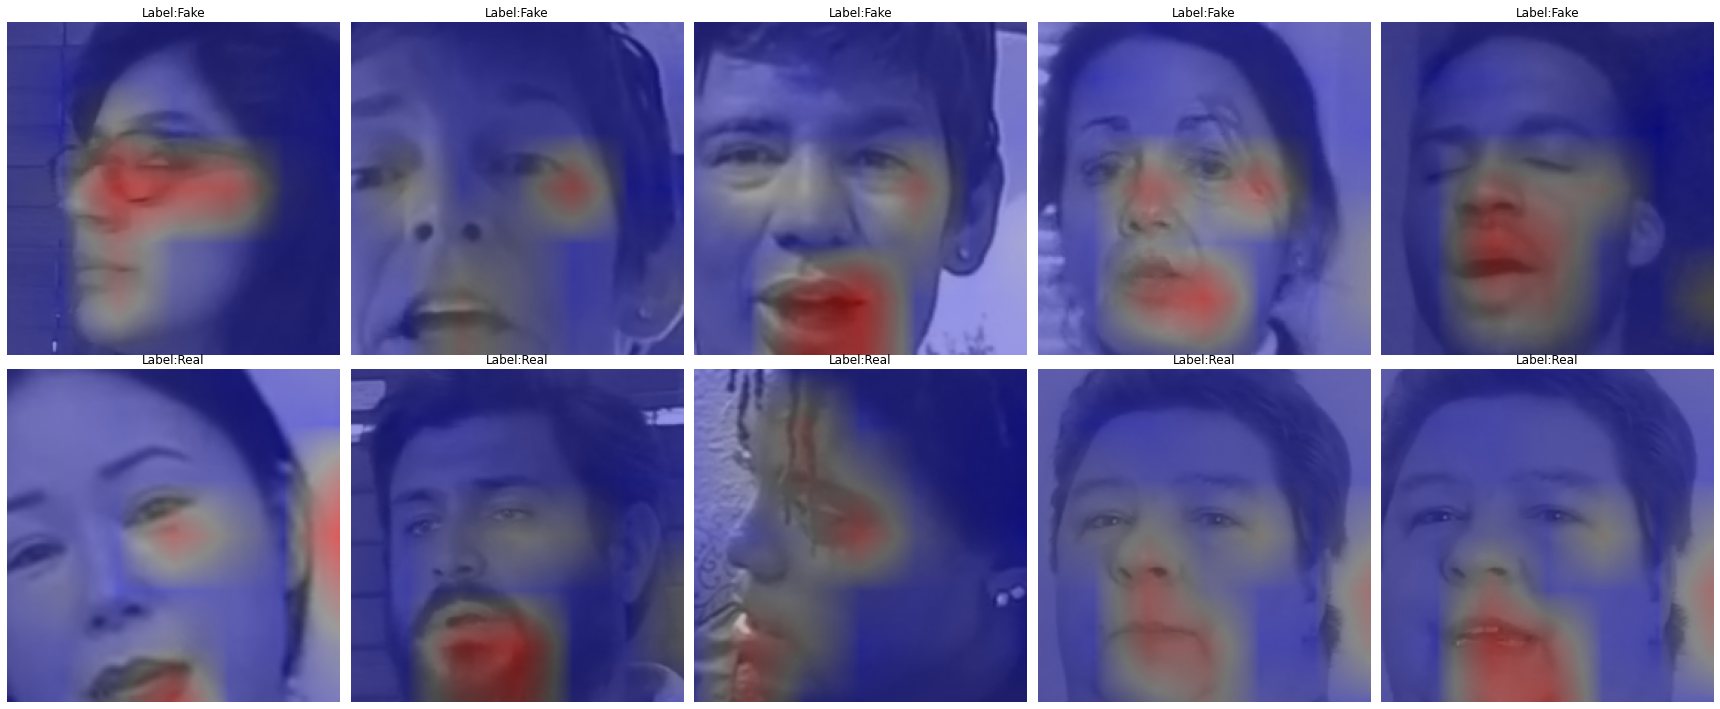

In [134]:
visualize_attention(model,test_loader,device,visualize_save_path)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3253: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


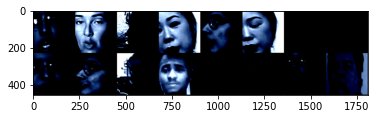

In [135]:
visualize_crop(test_loader)